# Features in POS_CASH_balance

In [1]:
### set up system path to access helpers functions

import sys
import os

# Get the path to the 'src' directory
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))

# Add the 'src' folder to sys.path
if src_path not in sys.path:
  sys.path.append(src_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers import *

In [3]:
# import the data

df = pd.read_csv('../data/POS_CASH_balance.csv')

df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [6]:
# save the SK_ID_PREV and SK_ID_CURR

engineered_pos = df[['SK_ID_PREV', 'SK_ID_CURR']].copy()
engineered_pos.duplicated().sum()

np.int64(9065033)

In [7]:
# drop duplicates

engineered_pos.drop_duplicates(keep='first', inplace=True)

In [8]:
engineered_pos

,SK_ID_PREV,SK_ID_CURR
0,1803195,182943
1,1715348,367990
2,1784872,397406
3,1903291,269225
4,2341044,334279
...,...,...
9996589,2672095,388093
9996600,2617335,172821
9996602,2452932,112263
9996603,1980876,448766


In [9]:
# check the values in SK_DPD

df['SK_DPD'].value_counts()

SK_DPD
0       9706131
1         21872
2         17358
3         14403
4         12350
         ...   
3161          1
3217          1
3323          1
3399          1
3082          1
Name: count, Length: 3400, dtype: int64

### New feature 1. pos_avg_DPD

In [11]:
# groupby SK_ID_PREV and the average DPD

pos_avg_DPD = pd.DataFrame(df.groupby('SK_ID_PREV')['SK_DPD'].mean()).reset_index()
pos_avg_DPD.columns = ['SK_ID_PREV', 'pos_avg_DPD']
pos_avg_DPD.isna().sum()


SK_ID_PREV     0
pos_avg_DPD    0
dtype: int64

In [12]:
# merge into the engineered df

engineered_pos = pd.merge(engineered_pos, pos_avg_DPD, on='SK_ID_PREV', how='outer')
engineered_pos

,SK_ID_PREV,SK_ID_CURR,pos_avg_DPD
0,1000001,158271,0.0
1,1000002,101962,0.0
2,1000003,252457,0.0
3,1000004,260094,0.0
4,1000005,176456,0.0
...,...,...,...
936320,2843494,292375,0.0
936321,2843495,260963,0.0
936322,2843497,451578,0.0
936323,2843498,393881,0.0


<Axes: >

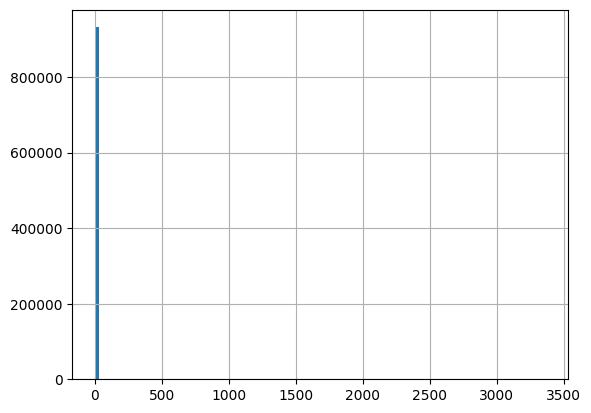

In [15]:
# plot the distribution

engineered_pos['pos_avg_DPD'].hist(bins=100)

In [16]:
# check the values in SK_DPD_DEF

df['SK_DPD_DEF'].value_counts()

SK_DPD_DEF
0       9887389
1         22134
2         14690
3         11652
4          9528
         ...   
1656          1
1291          1
1411          1
2448          1
2495          1
Name: count, Length: 2307, dtype: int64

### New feature 2. pos_avg_DPD_DEF

In [17]:
# groupby SK_ID_PREV and the average DPD_DEF

pos_avg_DPD_DEF = pd.DataFrame(df.groupby('SK_ID_PREV')['SK_DPD_DEF'].mean()).reset_index()
pos_avg_DPD_DEF.columns = ['SK_ID_PREV', 'pos_avg_DPD_DEF']
pos_avg_DPD_DEF.isna().sum()


SK_ID_PREV         0
pos_avg_DPD_DEF    0
dtype: int64

In [18]:
# merge into the engineered df

engineered_pos = pd.merge(engineered_pos, pos_avg_DPD_DEF, on='SK_ID_PREV', how='outer')
engineered_pos

,SK_ID_PREV,SK_ID_CURR,pos_avg_DPD,pos_avg_DPD_DEF
0,1000001,158271,0.0,0.0
1,1000002,101962,0.0,0.0
2,1000003,252457,0.0,0.0
3,1000004,260094,0.0,0.0
4,1000005,176456,0.0,0.0
...,...,...,...,...
936320,2843494,292375,0.0,0.0
936321,2843495,260963,0.0,0.0
936322,2843497,451578,0.0,0.0
936323,2843498,393881,0.0,0.0


In [19]:
# check the contract status value counts

df['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: count, dtype: int64

In [22]:
# separate into Active, Demand, Completed, Other

df['NAME_CONTRACT_STATUS'].replace({'Signed':'Active','Approved':'Active','Amortized debt':'Active',
                                    'Returned to the store':'Other','Canceled':'Other','XNA':'Other'}, inplace=True)
df['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active       9243932
Completed     744883
Demand          7065
Other           5478
Name: count, dtype: int64

In [24]:
# separate into binary columns

df['pos_status_active'] = (df['NAME_CONTRACT_STATUS'] == 'Active').astype(int)
df['pos_status_completed'] = (df['NAME_CONTRACT_STATUS'] == 'Completed').astype(int)
df['pos_status_demand'] = (df['NAME_CONTRACT_STATUS'] == 'Demand').astype(int)
df['pos_status_other'] = (df['NAME_CONTRACT_STATUS'] == 'Other').astype(int)

df


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,pos_status_active,pos_status_completed,pos_status_demand,pos_status_other
0,1803195,182943,-31,48.0,45.0,Active,0,0,1,0,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0,1,0,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0,1,0,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0,1,0,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0,1,0,0,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0,1,0,0,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0,1,0,0,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0,1,0,0,0


In [26]:
# groupby SK_ID_PREV

pos_status_per_loan = df.groupby('SK_ID_PREV')[['pos_status_active','pos_status_completed','pos_status_demand','pos_status_other']].sum()
pos_status_per_loan = pos_status_per_loan.reset_index()
pos_status_per_loan

,SK_ID_PREV,pos_status_active,pos_status_completed,pos_status_demand,pos_status_other
0,1000001,2,1,0,0
1,1000002,4,1,0,0
2,1000003,4,0,0,0
3,1000004,7,1,0,0
4,1000005,10,1,0,0
...,...,...,...,...,...
936320,2843494,2,1,0,0
936321,2843495,7,1,0,0
936322,2843497,21,0,0,0
936323,2843498,6,1,0,0


In [27]:
# merge into the engineered dataframe

engineered_pos = pd.merge(engineered_pos, pos_status_per_loan, on='SK_ID_PREV', how='outer')
engineered_pos

,SK_ID_PREV,SK_ID_CURR,pos_avg_DPD,pos_avg_DPD_DEF,pos_status_active,pos_status_completed,pos_status_demand,pos_status_other
0,1000001,158271,0.0,0.0,2,1,0,0
1,1000002,101962,0.0,0.0,4,1,0,0
2,1000003,252457,0.0,0.0,4,0,0,0
3,1000004,260094,0.0,0.0,7,1,0,0
4,1000005,176456,0.0,0.0,10,1,0,0
...,...,...,...,...,...,...,...,...
936320,2843494,292375,0.0,0.0,2,1,0,0
936321,2843495,260963,0.0,0.0,7,1,0,0
936322,2843497,451578,0.0,0.0,21,0,0,0
936323,2843498,393881,0.0,0.0,6,1,0,0


In [31]:
# check the values counts

df['MONTHS_BALANCE'].value_counts()

MONTHS_BALANCE
-10    216441
-11    216023
-9     215558
-12    214716
-8     214149
        ...  
-92     42283
-93     41025
-94     39900
-95     38514
-96     36448
Name: count, Length: 96, dtype: int64

<Axes: >

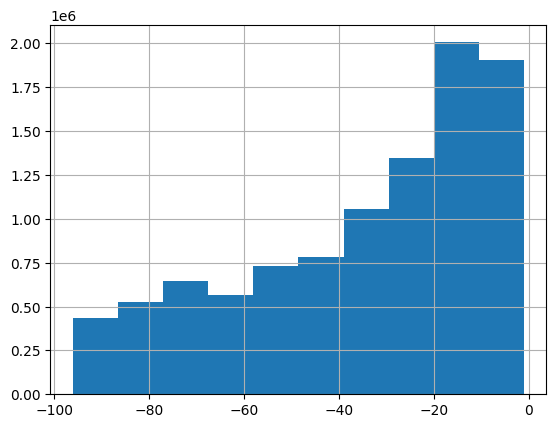

In [30]:
# check the distribution

df['MONTHS_BALANCE'].hist()

In [32]:
# check the values counts

df['CNT_INSTALMENT'].value_counts()

CNT_INSTALMENT
12.0    2496845
24.0    1517472
10.0    1243449
6.0     1065500
18.0     727394
         ...   
70.0          2
63.0          2
92.0          1
81.0          1
68.0          1
Name: count, Length: 73, dtype: int64

In [36]:
# no other features to engineer
# groupby engineered df on SK_ID_CURR

engineered_pos = engineered_pos.groupby('SK_ID_CURR').mean().reset_index()

# drop SK_ID_PREV
engineered_pos.drop(columns='SK_ID_PREV', inplace=True)
engineered_pos

,SK_ID_CURR,pos_avg_DPD,pos_avg_DPD_DEF,pos_status_active,pos_status_completed,pos_status_demand,pos_status_other
0,100001,0.875000,0.875000,3.500000,1.000000,0.0,0.0
1,100002,0.000000,0.000000,19.000000,0.000000,0.0,0.0
2,100003,0.000000,0.000000,8.666667,0.666667,0.0,0.0
3,100004,0.000000,0.000000,3.000000,1.000000,0.0,0.0
4,100005,0.000000,0.000000,10.000000,1.000000,0.0,0.0
...,...,...,...,...,...,...,...
337247,456251,0.000000,0.000000,8.000000,1.000000,0.0,0.0
337248,456252,0.000000,0.000000,6.000000,1.000000,0.0,0.0
337249,456253,0.277778,0.277778,5.000000,0.666667,0.0,0.0
337250,456254,0.000000,0.000000,10.000000,0.000000,0.0,0.0


In [42]:
# check for nulls

engineered_pos.isna().sum()

SK_ID_CURR              0
pos_avg_DPD             0
pos_avg_DPD_DEF         0
pos_status_active       0
pos_status_completed    0
pos_status_demand       0
pos_status_other        0
dtype: int64

In [48]:
# check for inf

(engineered_pos == np.inf).sum()

SK_ID_CURR              0
pos_avg_DPD             0
pos_avg_DPD_DEF         0
pos_status_active       0
pos_status_completed    0
pos_status_demand       0
pos_status_other        0
dtype: int64

In [49]:
# check for -inf

(engineered_pos == -np.inf).sum()

SK_ID_CURR              0
pos_avg_DPD             0
pos_avg_DPD_DEF         0
pos_status_active       0
pos_status_completed    0
pos_status_demand       0
pos_status_other        0
dtype: int64

In [50]:
# export engineered dataframe to csv

# engineered_pos.to_csv('../data/engineered_pos.csv', index=False)